## Data Questions

Data questions:
- Are there factors that make an earthquake more likely?
   -- Proximity to fault zone / areas of continental drift
- Are there factors that make an earthquake more deadly?
   --Secondary effects / volcanos / tsunamis / age of population / time of day / per capita gdp or economic factors
- Where would you live if you wanted to eliminate the risk of experiencing an earthquake?
   -- Points maximally distant from earthquakes
- Where would you avoid living?




#### Data cleaning tasks include:
1. Replace empty strings with NaN
2. Remove the footnotes from the 'Other Source Deaths' column
3. Convert Magnitude to a numeric
4. Create a new column ('deaths') that evaluates the four total-death columns ('PDE Total Deaths', 'Utsu Total Deaths', 'EM-DAT Total Deaths', and 'Other Source Deaths') and populates the new column with the highest value.
5. Explore the data in terms of when and where earthquakes occurred and how severe they were (magnitude, deaths, secondary effects).



In [1]:
import pandas as pd
import requests
import matplotlib
from bs4 import BeautifulSoup as BS
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import folium
from shapely.geometry import Point
import geopandas as gpd
from mpl_toolkits.basemap import Basemap
from folium import plugins
import json
import seaborn as sns
from pylab import rc, rcParams
import seaborn as sns
from matplotlib.pyplot import figure
from folium.plugins import MarkerCluster


pd.options.display.max_rows = 1500
pd.options.display.max_columns = 1500
%matplotlib inline



#### The [Requests](http://docs.python-requests.org/en/master/user/quickstart/) package makes working with HTTP easier

In [2]:
# create a Request object for the wikipedia page for the Turing Award
response = requests.get('https://en.wikipedia.org/wiki/List_of_deadly_earthquakes_since_1900')

# read the resulting HTML into a variable called result_text
result_text = response.text

In [3]:
print(type(response))
print(type(result_text))

<class 'requests.models.Response'>
<class 'str'>


In [4]:
#result_text

#### [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) is a package that helps pull data from HTML (and XML) files

In [5]:
# create the soup by constructing a BS object from the html page and the appropriate parser
earthquake = BS(result_text, 'lxml')

In [6]:
earthquake.findAll('table')[4].findAll('tr', limit=2)[0].findAll('th') 

[<th width="22%">Origin (<a class="mw-redirect" href="/wiki/UTC" title="UTC">UTC</a>)</th>,
 <th width="33%">Present-day country and link to Wikipedia article</th>,
 <th width="10%"><a href="/wiki/Latitude" title="Latitude">Lat</a></th>,
 <th width="10%"><a href="/wiki/Longitude" title="Longitude">Long</a></th>,
 <th width="8%">Depth (<a class="mw-redirect" href="/wiki/Km" title="Km">km</a>)</th>,
 <th width="6%">Magnitude</th>,
 <th width="9%">Secondary Effects</th>,
 <th width="10%">PDE Shaking Deaths</th>,
 <th width="10%">PDE Total Deaths</th>,
 <th width="10%">Utsu Total Deaths</th>,
 <th width="10%">EM-DAT Total Deaths</th>,
 <th width="12%">Other Source Deaths
 </th>]

In [7]:
column_headers = [th.getText() for th in 
                  earthquake.findAll('table')[4].findAll('tr', limit=2)[0].findAll('th')] 

In [8]:
column_headers

['Origin (UTC)',
 'Present-day country and link to Wikipedia article',
 'Lat',
 'Long',
 'Depth (km)',
 'Magnitude',
 'Secondary Effects',
 'PDE Shaking Deaths',
 'PDE Total Deaths',
 'Utsu Total Deaths',
 'EM-DAT Total Deaths',
 'Other Source Deaths\n']

In [9]:
data = []
table = earthquake.find('table', class_ = "sortable wikitable")
table_body = table.find('tbody')

rows = table_body.find_all('tr')[1:]
for row in rows:
    cols = row.find_all('td')
    cols = [col.text.strip() for col in cols]

    data.append(cols) 

In [10]:
earthquake_df = pd.DataFrame(data, columns = column_headers)


In [11]:
earthquake_df.head()

,Origin (UTC),Present-day country and link to Wikipedia article,Lat,Long,Depth (km),Magnitude,Secondary Effects,PDE Shaking Deaths,PDE Total Deaths,Utsu Total Deaths,EM-DAT Total Deaths,Other Source Deaths\n
0,1900-05-11 17:23,Japan,38.700,141.100,5,7.0 MJMA,,,,,,
1,1900-07-12 06:25,Turkey,40.300,43.100,,5.9 Muk,,,,140,,
2,1900-10-29 09:11,Venezuela,11.000,-66.000,0,7.7 Mw,,,,,,
3,1901-02-15 00:00,China,26.000,100.100,0,6.5 Ms,,,,,,
4,1901-03-31 07:11,Bulgaria,43.400,28.700,,6.4 Muk,,,,4,,


In [12]:
 earthquake_df.columns = [
    'Origin(UTC)',
    'Country',
    'Lat',
    'Long',
    'Depth(km)',
    'Magnitude',
    'Secondary Effects',
    'PDE Shaking Deaths',
    'PDE Total Deaths',
    'UTsu Total Deaths',
    'EM-Dat Total Deaths',
    'Other Source Deaths']

In [13]:
earthquake.head()

[<meta charset="utf-8"/>,
 <title>List of deadly earthquakes since 1900 - Wikipedia</title>,
 <script>document.documentElement.className="client-js";RLCONF={"wgCanonicalNamespace":"","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":0,"wgPageName":"List_of_deadly_earthquakes_since_1900","wgTitle":"List of deadly earthquakes since 1900","wgCurRevisionId":898836578,"wgRevisionId":898836578,"wgArticleId":11673441,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":["CS1 errors: deprecated parameters","CS1 errors: missing periodical","Articles needing additional references from July 2017","All articles needing additional references","Articles needing cleanup from July 2017","All pages needing cleanup","Cleanup tagged articles with a reason field from July 2017","Wikipedia pages needing cleanup from July 2017","Articles with obsolete information from July 2017","All Wikipedia articles in need of updating","Articles with multiple maint

#### Explore the methods and attributes of the soup object - here are a few

In [14]:
earthquake_df.shape

(1340, 12)

In [15]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
Origin(UTC)            1340 non-null object
Country                1340 non-null object
Lat                    1340 non-null object
Long                   1340 non-null object
Depth(km)              1340 non-null object
Magnitude              1340 non-null object
Secondary Effects      1340 non-null object
PDE Shaking Deaths     1340 non-null object
PDE Total Deaths       1340 non-null object
UTsu Total Deaths      1340 non-null object
EM-Dat Total Deaths    1340 non-null object
Other Source Deaths    1338 non-null object
dtypes: object(12)
memory usage: 125.8+ KB


In [16]:
earthquake_df = earthquake_df.replace('\n','',regex=True)

In [17]:
earthquake_df['EM-Dat Total Deaths'] = earthquake_df['EM-Dat Total Deaths'].replace('\[.+', '', regex=True)
earthquake_df['EM-Dat Total Deaths'] = earthquake_df['EM-Dat Total Deaths'].replace("|","",regex=True)

In [18]:
earthquake_df['Other Source Deaths'] = earthquake_df['Other Source Deaths'].str.replace('\[.+', '')
earthquake_df['Other Source Deaths'] = earthquake_df['Other Source Deaths'].str.replace('\s+\(.+', '')
earthquake_df['Other Source Deaths'] = earthquake_df['Other Source Deaths'].str.replace('\\n','')
earthquake_df['Other Source Deaths']= earthquake_df['Other Source Deaths'].str.replace('\+', '')
earthquake_df['Other Source Deaths'] = earthquake_df['Other Source Deaths'].str.replace('\*', '')
earthquake_df['Other Source Deaths'] = earthquake_df['Other Source Deaths'].str.replace(',', '')

In [19]:
earthquake_df['Magnitude'] = earthquake_df['Magnitude'].replace('\[\d+\]', '', regex=True)

In [20]:
earthquake_df['Depth(km)'] = earthquake_df['Depth(km)'].replace('?', '')

In [21]:
earthquake_df['Country'] = earthquake_df['Country'].replace(',', "", regex=True)
earthquake_df['Long']= earthquake_df['Long'].replace('??', '')
earthquake_df['Lat']= earthquake_df['Lat'].replace('?', '')

In [22]:
earthquake_df['Magnitude'] = earthquake_df['Magnitude'].str.split(n=-1, expand=True)


In [23]:
earthquake_df['Country'] = earthquake_df['Country'].str.replace('\s+\(.+', '')

In [24]:
earthquake_df['Country'] = earthquake_df['Country'].str.replace(',', "", regex=True)

In [25]:
earthquake_df['Origin(UTC)']= pd.to_datetime(earthquake_df['Origin(UTC)'], yearfirst = True)

In [26]:
cols_float = ['Lat', 'Long', 'Depth(km)','Magnitude']
earthquake_df[cols_float] = earthquake_df[cols_float].apply(pd.to_numeric)

In [27]:
earthquake_df['Lat'] = earthquake_df['Lat'].astype('float')
earthquake_df['Long'] = earthquake_df['Long'].astype('float')

In [28]:
cols_int = ['PDE Shaking Deaths', 'PDE Total Deaths', 'UTsu Total Deaths','EM-Dat Total Deaths', 'Other Source Deaths']
earthquake_df[cols_int] = earthquake_df[cols_int].apply(pd.to_numeric)

In [29]:
earthquake_df = earthquake_df.replace('', np.NAN)
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1340 entries, 0 to 1339
Data columns (total 12 columns):
Origin(UTC)            1340 non-null datetime64[ns]
Country                1340 non-null object
Lat                    1324 non-null float64
Long                   1324 non-null float64
Depth(km)              1249 non-null float64
Magnitude              1339 non-null float64
Secondary Effects      373 non-null object
PDE Shaking Deaths     738 non-null float64
PDE Total Deaths       749 non-null float64
UTsu Total Deaths      1027 non-null float64
EM-Dat Total Deaths    559 non-null float64
Other Source Deaths    37 non-null float64
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 125.8+ KB


In [30]:
earthquake_df['deaths'] =  earthquake_df[['PDE Total Deaths','UTsu Total Deaths','EM-Dat Total Deaths','Other Source Deaths']].max(axis =1)

In [31]:
earthquake_df= earthquake_df.sort_values(by ='Depth(km)', ascending=False).reset_index(drop=True)

In [32]:
earthquake_df['Country'].value_counts().head()

China        166
Indonesia     97
Turkey        95
Iran          91
Japan         82
Name: Country, dtype: int64

In [33]:
earthquake_df['Secondary Effects'].value_counts()

L         165
T         144
T,L        26
L,Lq       10
F           9
T,F         5
T,L,Lq      4
Lq          4
T,Lq        2
T,LF        2
L,F,Lq      1
L,F         1
Name: Secondary Effects, dtype: int64

In [34]:
earthquake_df['Secondary Effects'].unique()

array([nan, 'L', 'T', 'F', 'Lq', 'T,L', 'L,Lq', 'T,L,Lq', 'T,Lq', 'T,F',
       'T,LF', 'L,F,Lq', 'L,F'], dtype=object)

In [35]:
earthquake_df['Secondary Effects'] = earthquake_df['Secondary Effects'].str.replace(',', "", regex=True)

In [36]:
earthquake_df = earthquake_df.join(earthquake_df['Secondary Effects'] \
    .str.replace(r'LF', 'L,F', regex = True)\
    .str.replace(r'TL','T,L', regex = True)\
    .str.replace(r'FLq', 'F,Lq', regex = True)\
    .str.replace(r'LLq', 'L,Lq', regex = True)\
    .str.replace(r'TLq', 'T,Lq', regex = True)\
    .str.replace(r'TLLq', 'T,L,Lq', regex = True)\
    .str.replace(r'TF', 'T,F', regex = True)\
    .str.replace(r'TLF', 'T,L,F', regex = True)\
    .str.get_dummies(','))

In [37]:
earthquake_df['Secondary Effects'].unique()

array([nan, 'L', 'T', 'F', 'Lq', 'TL', 'LLq', 'TLLq', 'TLq', 'TF', 'TLF',
       'LFLq', 'LF'], dtype=object)

In [38]:
earthquake_df = earthquake_df.rename(columns={'Origin(UTC)': 'Date'})

In [39]:
earthquake_df['Year'] = earthquake_df['Date'].dt.year

In [40]:
#percentage of secondary effects
Landslide1 =len(earthquake_df[earthquake_df['L']>0])/1340*100
Tstunami1 =len(earthquake_df[earthquake_df['T']>0])/1340*100
Liquefaction1 =len(earthquake_df[earthquake_df['Lq']>0])/1340*100
Fire1=len(earthquake_df[earthquake_df['F']>0])/1340*100
d = {'Landslide': Landslide1,'Tsunami': Tstunami1,'Liquefaction': Liquefaction1,'Fire' :Fire1}
df =pd.DataFrame(d, index=[0])

df1 = df.T

df1.reset_index(inplace = True)
df1.rename(columns = {'index': 'Secondary Effects', 0: 'Percentage'}, inplace = True)

df1.head()


,Secondary Effects,Percentage
0,Landslide,15.597015
1,Tsunami,13.656716
2,Liquefaction,1.567164
3,Fire,1.343284


<Figure size 1800x1080 with 0 Axes>

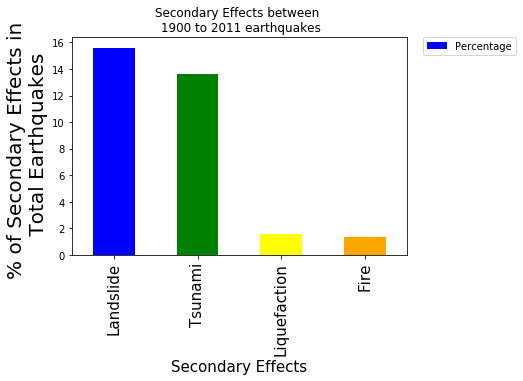

In [41]:
plt.figure(figsize=(25,15))
df1.plot.bar (x = 'Secondary Effects', y='Percentage',title= "Secondary Effects between \n 1900 to 2011 earthquakes", color=['blue','green','yellow','orange'])
#plt.xticks(ticks, ['Landslide', 'tsunami','Liquefaction','Fire','Liquid']
plt.xlabel('Secondary Effects', fontsize=15)
plt.ylabel('% of Secondary Effects in \n Total Earthquakes', fontsize=20);
plt.xticks(size =15)
# legend_kwds = ['Landslide', 'Tsunami','Liquefaction','Fire']
# plt.legend(legend_kwds = legend_kwds)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.savefig('percentageSE.pdf')

### 30% of the total earthquakes between 1900- 2011 has secondary effects. Top secondary effects are Landslide(~16%), and Tsunami(~14%) while Liquefaction and Fire constitute< 1.5% This suggests that there are other secondary effects leading to deaths during earthquakes. 

### Question: Does seconday effects are related to higher magnitude or there is not relation to Magnitude? 

#### Cleaned earthquake_df

In [42]:
earthquake_df= earthquake_df.sort_values(by ='deaths', ascending=False).reset_index(drop=True)
earthquake_df.columns

Index(['Date', 'Country', 'Lat', 'Long', 'Depth(km)', 'Magnitude',
       'Secondary Effects', 'PDE Shaking Deaths', 'PDE Total Deaths',
       'UTsu Total Deaths', 'EM-Dat Total Deaths', 'Other Source Deaths',
       'deaths', 'F', 'L', 'Lq', 'T', 'Year'],
      dtype='object')

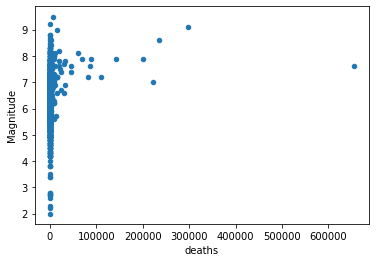

In [43]:
earthquake_df.plot(x = 'deaths', y ='Magnitude', kind ='scatter')

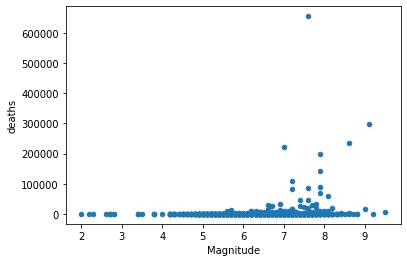

In [44]:
earthquake_df.plot(x = 'Magnitude', y ='deaths', kind = 'scatter')

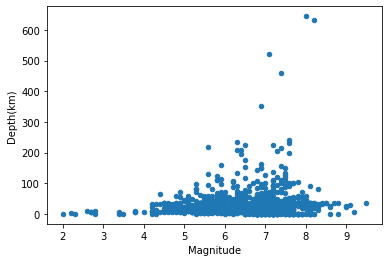

In [45]:
earthquake_df.plot(x = 'Magnitude', y ='Depth(km)', kind ='scatter')

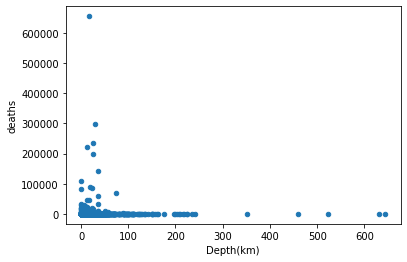

In [46]:
earthquake_df.plot(x = 'Depth(km)', y ='deaths', kind ='scatter')

### Correlation between Depth, Magnitude, and Deaths

In [47]:
print(earthquake_df[['Depth(km)','Magnitude']].corr())
print('''''')
print(earthquake_df[['Depth(km)','deaths']].corr())
print('''''')
print(earthquake_df[['Magnitude','deaths']].corr())

#np.corrcoef(earthquake_df1['Magnitude'],earthquake_df1['Depth(km)'])

           Depth(km)  Magnitude
Depth(km)   1.000000   0.164748
Magnitude   0.164748   1.000000

           Depth(km)    deaths
Depth(km)   1.000000 -0.022377
deaths     -0.022377  1.000000

           Magnitude    deaths
Magnitude   1.000000  0.139654
deaths      0.139654  1.000000


### Looking at the Correlation data there doesnot seem to have a very strong correlation between the groups. There  is a negative correlation between Depth and deaths. Need to check if there is correlation at the different levels of Magnitude, Depth and deaths. 

In [48]:
earthquake_df.describe()

,Lat,Long,Depth(km),Magnitude,PDE Shaking Deaths,PDE Total Deaths,UTsu Total Deaths,EM-Dat Total Deaths,Other Source Deaths,deaths,F,L,Lq,T,Year
count,1324.000000,1324.000000,1249.000000,1339.000000,738.000000,749.000000,1027.000000,559.000000,37.000000,1273.000000,1340.000000,1340.000000,1340.000000,1340.000000,1340.000000
mean,21.394194,39.213427,29.550681,6.398133,1506.390244,2019.323097,1580.013632,3319.295170,18161.243243,2478.362922,0.013433,0.155970,0.015672,0.136567,1972.200746
std,21.461868,80.133871,44.899987,0.967825,24589.605189,26877.253336,12620.035353,18661.234365,53945.531960,24002.086927,0.115162,0.362963,0.124248,0.343518,29.176947
min,-54.000000,-178.162000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1900.000000
25%,8.237500,-0.592000,10.000000,5.700000,1.000000,1.000000,2.000000,3.000000,68.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1953.000000
50%,29.004500,51.575000,18.000000,6.400000,3.000000,4.000000,11.000000,17.000000,215.000000,10.000000,0.000000,0.000000,0.000000,0.000000,1980.000000
75%,38.000000,103.675000,35.000000,7.100000,16.750000,24.000000,103.000000,181.500000,2489.000000,92.000000,0.000000,0.000000,0.000000,0.000000,1995.000000
max,66.226000,178.291000,644.600000,9.500000,655237.000000,655237.000000,242800.000000,242000.000000,231000.000000,655237.000000,1.000000,1.000000,1.000000,1.000000,2018.000000


/Users/hari/anaconda3/envs/NSSdatascience/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/hari/anaconda3/envs/NSSdatascience/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


,Magnitude Range,Frequency,Percentage
0,5.5-6.5,477.0,35.60
1,6.5-7.5,481.0,35.90
2,7.5-8.5,172.0,12.84
3,8.5-9.5,13.0,0.97


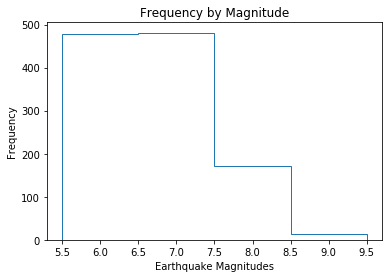

In [49]:
total = len(earthquake_df)
count, bins, patch = plt.hist(earthquake_df["Magnitude"], histtype = 'step', range=(5.5,9.5), bins =4)
plt.xlabel("Earthquake Magnitudes")
plt.ylabel("Frequency")
plt.title("Frequency by Magnitude")
magnitude_range = pd.DataFrame()
for i, x in enumerate(count):
    x = str(bins[i])+ "-"+str(bins[i+1])
    y = count[i]
    percentage = round((count[i]/total) * 100, 2)
    magnitude_range = magnitude_range.append(pd.Series([x, y, percentage]), ignore_index=True)
    
magnitude_range.columns = ['Magnitude Range', 'Frequency', 'Percentage']
magnitude_range

<Figure size 1800x1080 with 0 Axes>

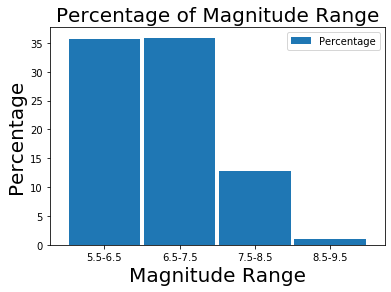

In [50]:
plt.figure(figsize=(25,15))
magnitude_range.reset_index().plot.bar(x='Magnitude Range', y='Percentage',width = 0.95)
plt.title("Percentage of Magnitude Range", size = 20)
plt.ylabel('Percentage', fontsize=20)
plt.xlabel('Magnitude Range', fontsize=20)
plt.xticks(size =10, rotation=0)
plt.yticks(size =10);

,Depth(km),Frequency,Percentage
0,0.0-130.0,1220.0,91.04
1,130.0-260.0,24.0,1.79
2,260.0-390.0,1.0,0.07
3,390.0-520.0,1.0,0.07
4,520.0-650.0,3.0,0.22


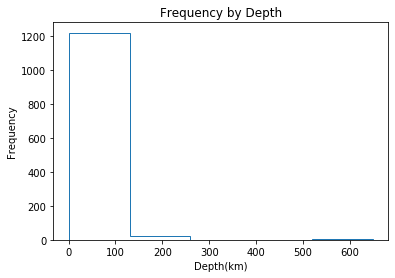

In [51]:
total = len(earthquake_df)
count, bins, patch = plt.hist(earthquake_df["Depth(km)"], histtype = 'step', range=(0,650), bins =5)
plt.xlabel("Depth(km)")
plt.ylabel("Frequency")
plt.title("Frequency by Depth")
depth_range = pd.DataFrame()
for i, x in enumerate(count):
    x = str(bins[i])+ "-"+str(bins[i+1])
    y = count[i]
    percentage = round((count[i]/total) * 100, 2)
    depth_range = depth_range.append(pd.Series([x, y, percentage]), ignore_index=True)
    
depth_range.columns = ['Depth(km)', 'Frequency', 'Percentage']
depth_range

<Figure size 1440x1080 with 0 Axes>

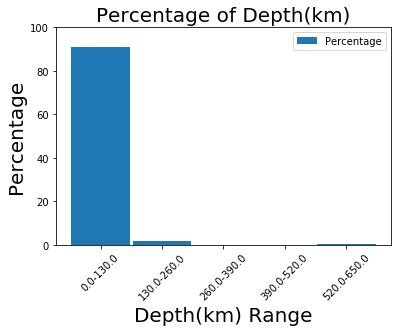

In [52]:
plt.figure(figsize=(20,15))
depth_range.reset_index().plot.bar(x='Depth(km)', y='Percentage',width = 0.95)
plt.title("Percentage of Depth(km)", size = 20)
plt.ylabel('Percentage', fontsize=20)
plt.xlabel('Depth(km) Range', fontsize=20)
plt.xticks(size =10, rotation=45)
plt.yticks(size =10)
plt.ylim([0, 100]);

Text(0.5, 0, 'Magnitude')

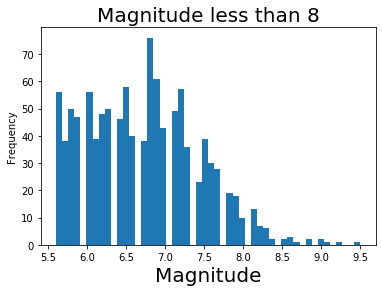

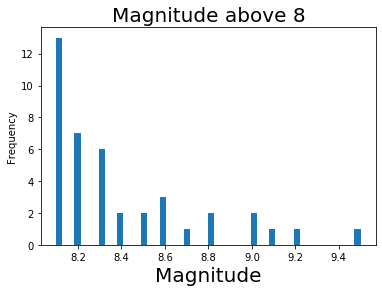

In [53]:
plt.figure()
Mag1 = earthquake_df[(earthquake_df['Magnitude'] >5.5)]['Magnitude']
Mag1.plot(kind = 'hist', stacked = True, bins = 50)
plt.title('Magnitude less than 8', fontsize = 20)
plt.xlabel('Magnitude', fontsize = 20)

plt.figure()
Mag2 = earthquake_df[(earthquake_df['Magnitude'] >8)]['Magnitude']
Mag2.plot(kind = 'hist', stacked = True, bins = 50)
plt.title('Magnitude above 8', fontsize = 20)
plt.xlabel('Magnitude', fontsize = 20)

Text(0.5, 0, 'Magnitude')

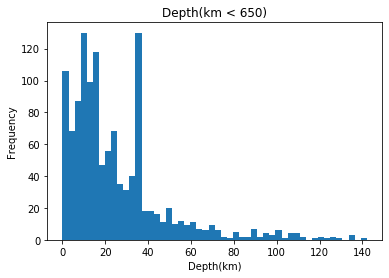

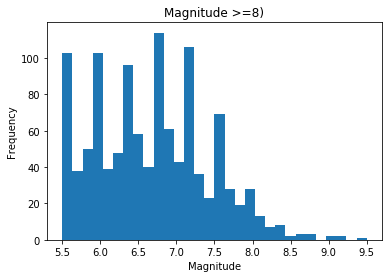

In [54]:
plt.figure()
depth = earthquake_df[(earthquake_df['Depth(km)'] <150)]['Depth(km)']
depth.plot(kind = 'hist', stacked = True, bins = 50)
plt.title('Depth(km < 650)')
plt.xlabel('Depth(km)')

plt.figure()
Mag = earthquake_df[(earthquake_df['Magnitude'] >=5.5)]['Magnitude']
Mag.plot(kind = 'hist', stacked = True, bins = 30)
plt.title('Magnitude >=8)')
plt.xlabel('Magnitude')


In [55]:
earthquake_df.set_index('Date', drop = False, inplace = True)

Text(0, 0.5, 'Deaths')

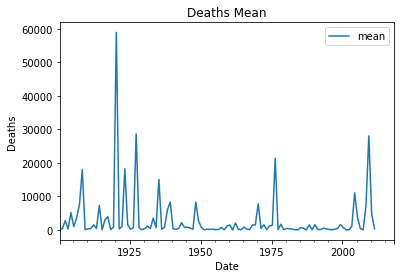

In [56]:
# Frequency of Deaths by year
earthquake_df['deaths'].resample('365d').apply([np.mean]).plot()
plt.title('Deaths Mean')
plt.ylabel('Deaths')

## Mapping Coordinates of EarthQuake

In [57]:
earthquake_df[earthquake_df.Lat.isnull()].shape

(16, 18)

In [58]:
earthquake_df[earthquake_df.Long.isnull()].shape

(16, 18)

In [59]:
earthquake_df.dropna(subset = ['Lat','Long'], how ='any',thresh = 1,inplace = True)

In [60]:
earthquake_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1324 entries, 1976-07-27 19:42:00 to 2008-08-21 12:24:00
Data columns (total 18 columns):
Date                   1324 non-null datetime64[ns]
Country                1324 non-null object
Lat                    1324 non-null float64
Long                   1324 non-null float64
Depth(km)              1247 non-null float64
Magnitude              1323 non-null float64
Secondary Effects      370 non-null object
PDE Shaking Deaths     738 non-null float64
PDE Total Deaths       748 non-null float64
UTsu Total Deaths      1027 non-null float64
EM-Dat Total Deaths    558 non-null float64
Other Source Deaths    27 non-null float64
deaths                 1261 non-null float64
F                      1324 non-null int64
L                      1324 non-null int64
Lq                     1324 non-null int64
T                      1324 non-null int64
Year                   1324 non-null int64
dtypes: datetime64[ns](1), float64(10), int64(5), object(2

In [61]:
map = folium.Map(location=[20,0],zoom_start=2, tiles = 'StamenTerrain')

In [62]:
with open('/Users/hari/NSSdatascience/Tectonic_plates/tectonicplates/GeoJSON/PB2002_plates.json') as p:
      plates = json.load(p)

FileNotFoundError: [Errno 2] No such file or directory: '/Users/hari/NSSdatascience/Tectonic_plates/tectonicplates/GeoJSON/PB2002_plates.json'

In [ ]:
folium.GeoJson(plates).add_to(map)

In [ ]:
map


### Create a New DataFrame 

In [ ]:
earthquake_df1 = earthquake_df[['Year','Country','Depth(km)','Magnitude','F','L',"Lq",'T','deaths', 'Lat','Long']]

In [ ]:
earthquake_df1=earthquake_df1.rename(columns ={'F':'Fire','L':'Landslide','Lq':'Liquefaction','T':'Tsunami'})

#### Change dummy variable to alphabets showing secondary Effects

In [ ]:
earthquake_df1['Fire'] = earthquake_df1['Fire'].replace(1, 'F')
earthquake_df1['Landslide'] = earthquake_df1['Landslide'].replace(1, 'L')
earthquake_df1['Liquefaction'] = earthquake_df1['Liquefaction'].replace(1, 'Lq')
earthquake_df1['Tsunami'] = earthquake_df1['Tsunami'].replace(1, 'T')

In [ ]:
new_df= earthquake_df1[((earthquake_df1['Fire'] == 'F') | (earthquake_df1['Landslide'] == 'L')) | ((earthquake_df1['Tsunami'] == 'T')  | (earthquake_df1['Liquefaction'] == 'F'))].sort_values(ascending =False, by = "deaths")

In [ ]:
new_df.shape


In [ ]:
new_df.describe()

In [ ]:
print(new_df[new_df.Fire== 'F'].shape)
print(new_df[new_df.Landslide== 'L'].shape)
print(new_df[new_df.Liquefaction== 'Lq'].shape)
print(new_df[new_df.Tsunami== 'T'].shape)

### Creating Dataframe with multiple options to analyze secondary effects. 
##Are deaths related to cumulative effect of secondary effects following earthquakes?

In [ ]:

new_df1= new_df[(new_df['Fire'] == 'F') & (new_df['Landslide'] == 'L') &(new_df['Liquefaction'] == 'Lq')]#.groupby(['deaths','Magnitude','Country']).sum()
new_df2= new_df[(new_df['Landslide'] == 'L') & (new_df['Liquefaction'] == 'Lq') & (new_df['Tsunami'] == 'T')]#.groupby(['deaths','Magnitude','Country']).max()
new_df3= new_df[(new_df['Liquefaction'] == 'Lq') & (new_df['Landslide'] == 'L') & (new_df['Tsunami'] != 'T') & (new_df['Fire'] != 'F') ]#.groupby(['deaths','Magnitude','Country']).max()
new_df4= new_df[(new_df['Tsunami'] == 'T') & (new_df['Liquefaction'] == 'Lq') & (new_df['Landslide'] != 'L')]#.groupby(['deaths','Magnitude','Country']).max()
                        
new_df5= new_df[(new_df['Tsunami'] == 'T') & (new_df['Landslide'] == 'L') & (new_df['Fire'] != 'F') & (new_df['Liquefaction'] != 'Lq')]#.groupby(['deaths','Magnitude','Country']).max()
new_df6= new_df[(new_df['Tsunami'] == 'T') & (new_df['Liquefaction'] != 'Lq') &(new_df['Fire'] != 'F') & (new_df['Landslide'] != 'L')]#.groupby(['deaths','Magnitude','Country']).max()             
new_df7= new_df[(new_df['Fire'] == 'F') & (new_df['Liquefaction'] != 'Lq') & (new_df['Tsunami']!= 'T') & (new_df['Landslide'] != 'L')]#.groupby(['deaths','Magnitude','Country']).max()
new_df8= new_df[(new_df['Fire'] != 'F') & (new_df['Liquefaction'] != 'Lq') & (new_df['Tsunami']!= 'T') & (new_df['Landslide'] == 'L')]#.groupby(['deaths','Magnitude','Country']).max()


####  Fire, Landslide and Liquefaction together occured once during Japan earthquake in 1995 with a magnitude of 6.9 causing 6432 deaths

In [ ]:
new_df1.reset_index()

### Landslide,liquefaction, tsunami occured 4 times during earthquakes. Interestingly in three countries there were no major deaths inspite of higher magnitude of earthquake. 

In [ ]:
new_df2.reset_index().head(4)


### Landslide, liquefaction together occured  9 times during earthquakes . 

In [ ]:
new_df3.reset_index().head()
#print(new_df3[['Magnitude','deaths']].corr())

### Deaths during earthquakes with Liquefaction and tsunami together occured only 2 times

In [ ]:
new_df4.reset_index().head(10)


####  Tsunami, Landslide, 25 times during earthquakes
#### All four secondary effects didnot occur together anytime or hasnot been reported

In [ ]:
new_df5.reset_index().head()
#print(new_df5[['Magnitude','deaths']].corr())

####  Tsunami associated with earthquakes 128 

In [ ]:
new_df6.reset_index().sort_values(ascending = False, by = 'deaths').fillna(0).head()

## Fire associated with earthquake

In [ ]:
new_df7.reset_index()

### Landslide associated with Earthquakes

In [ ]:
print(new_df8.reset_index().shape)
print(new_df8[['Magnitude','deaths']].corr())

In [ ]:
matplotlib.style.use('ggplot')

plt.scatter('Magnitude', 'deaths', data = new_df8)
plt.show()

In [ ]:
merged = pd.concat([new_df1, new_df2, new_df3, new_df4,new_df5,new_df6,new_df7,new_df8])

In [ ]:
merged.reset_index(inplace = True)
merged.head().sort_values(ascending = True, by ='Country').head(100)

In [ ]:
merged['coords'] = list(zip(merged.Long, merged.Lat))
merged['coords'] = merged['coords'].apply(Point)
secondaryeffects_geo = gpd.GeoDataFrame(merged, geometry='coords')
secondaryeffects_geo.crs = {'init': 'epsg:4326'}
secondaryeffects_geo.head(400)
secondaryeffects_geo.head()

In [ ]:

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(figsize=(25,5))
ax.axis('off')

In [ ]:
ax = secondaryeffects_geo.plot(figsize = (25,5), markersize = 10, color = 'green', alpha = 0.5)
ax.axis('off')

In [ ]:
ax = world.plot(color='#EEE9E9', linewidth=0.5,edgecolor ='black', figsize =(25,5))
ax.axis('off')
legend_kwds = {'title': 'Magnitude', 'shadow': False,
               'loc': 'upper right', 'bbox_to_anchor': (1, 1.03), 'ncol': 1}
secondaryeffects_geo.plot(column = 'Magnitude',markersize = secondaryeffects_geo['deaths']/100, alpha =1, ax = ax, cmap= 'tab10', legend = True,legend_kwds = legend_kwds)
plt.title("Deaths in 100's Due to Secondary Effects")
plt.text(235,100,'Magnitude')
plt.savefig('secondaryeffects2.pdf')

In [ ]:
merged.sort_values(ascending = False, by = 'deaths').head()

In [ ]:
map2 = folium.Map(location=[20,0],zoom_start=4, tiles = 'StamenTerrain')

In [ ]:

from folium.plugins import MarkerCluster

marker_cluster = MarkerCluster().add_to(map2)

for i in range(1,len(merged)):
                            
    if merged.iloc[i]['Landslide'] =='L':
        folium.CircleMarker([merged.iloc[i]['Lat'], merged.iloc[i]['Long']],
                            radius=merged.iloc[i]['deaths'], color='black',
                            popup=merged.iloc[i]['Magnitude'].astype(str)).add_to(marker_cluster)
    if merged.iloc[i]['Tsunami'] =='T':
        folium.CircleMarker([merged.iloc[i]['Lat'], merged.iloc[i]['Long']],
                            radius=merged.iloc[i]['deaths'], color='red',
                            popup=merged.iloc[i]['Magnitude'].astype(str)).add_to(marker_cluster)
    if merged.iloc[i]['Liquefaction'] =='Lq':
        folium.CircleMarker([merged.iloc[i]['Lat'], merged.iloc[i]['Long']],
                            radius=merged.iloc[i]['deaths'], color='pink',
                            popup=merged.iloc[i]['Magnitude'].astype(str)).add_to(marker_cluster)
        
    if merged.iloc[i]['Fire'] =='F':
        folium.CircleMarker([merged.iloc[i]['Lat'], merged.iloc[i]['Long']],
                            radius=merged.iloc[i]['deaths'], color='blue',
                            popup=merged.iloc[i]['Magnitude'].astype(str)).add_to(marker_cluster)


map2

In [ ]:
#     if merged.iloc[i]['Tsunami'] =='T':
#         folium.CircleMarker([merged.iloc[i]['Lat'], merged.iloc[i]['Long']],
#                             radius=merged.iloc[i]['deaths'], color='red',
#                             popup=merged.iloc[i]['Magnitude'].astype(str)).add_to(marker_cluster)
#     if merged.iloc[i]['Liquefaction'] =='Lq':
#         folium.CircleMarker([merged.iloc[i]['Lat'], merged.iloc[i]['Long']],
#                             radius=merged.iloc[i]['deaths'], color='pink',
#                             popup=merged.iloc[i]['Magnitude'].astype(str)).add_to(marker_cluster)
        
#     if merged.iloc[i]['Fire'] =='F':
#         folium.CircleMarker([merged.iloc[i]['Lat'], merged.iloc[i]['Long']],
#                             radius=merged.iloc[i]['deaths'], color='blue',
#                             popup=merged.iloc[i]['Magnitude'].astype(str)).add_to(marker_cluster)



In [ ]:
# with open('/Users/hari/NSSdatascience/Tectonic_plates/tectonicplates/GeoJSON/PB2002_plates.json') as p:
#       plates = json.load(p)


In [ ]:
#gpd.Json(plates).add_to(world)

In [ ]:
print('F,L,Lq')
print(new_df1.deaths.sum())
print('L,Lq,T')
print(new_df2.deaths.sum())
print('L,Lq')
print(new_df3.deaths.sum())
print('Lq,T')
print(new_df4.deaths.sum())
print('L,T')
print(new_df5.deaths.sum())
print('T')
print(new_df6.deaths.sum())
print('F')
print(new_df7.deaths.sum())
print('L')
print(new_df8.deaths.sum())
print('Total')
print(earthquake_df.deaths.sum())

In [ ]:
effects = {'Fire, Landslide, Liquefaction': new_df1.deaths.sum(), 'Landslide, Liquefaction,Tsunami': new_df2.deaths.sum(),'Landslide, Liquefaction': new_df3.deaths.sum(), 
           'Liquefaction,Tsunami': new_df4.deaths.sum(), 'Landslide,Tsunami': new_df5.deaths.sum(),'Tsunami': new_df6.deaths.sum(),
           'Fire': new_df7.deaths.sum(), 'Landslide': new_df8.deaths.sum(),'Total': earthquake_df.deaths.sum()}

In [ ]:
secondary_deaths = pd.DataFrame(effects, index=[0]).T
secondary_deaths.reset_index(inplace = True)
secondary_deaths.rename(columns = {'index': 'Secondary Effects', 0: 'Deaths'}, inplace = True)
secondary_deaths.sort_values(ascending = False, by ='Deaths')

In [ ]:
plt.figure(figsize=(25,15))
secondary_deaths.plot.barh(x ='Secondary Effects', y= 'Deaths',width = 0.95, color=['darkgrey','blue','red','black','green','orange','blue','green','yellow'])
plt.title("Secondary Deaths \n compared to Total Deaths", size = 15)
plt.ylabel('Secondary Effects', fontsize=20)
plt.xlabel('Number of Deaths', fontsize=20)
plt.xticks(size =12, rotation=45)
plt.yticks(size =15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
